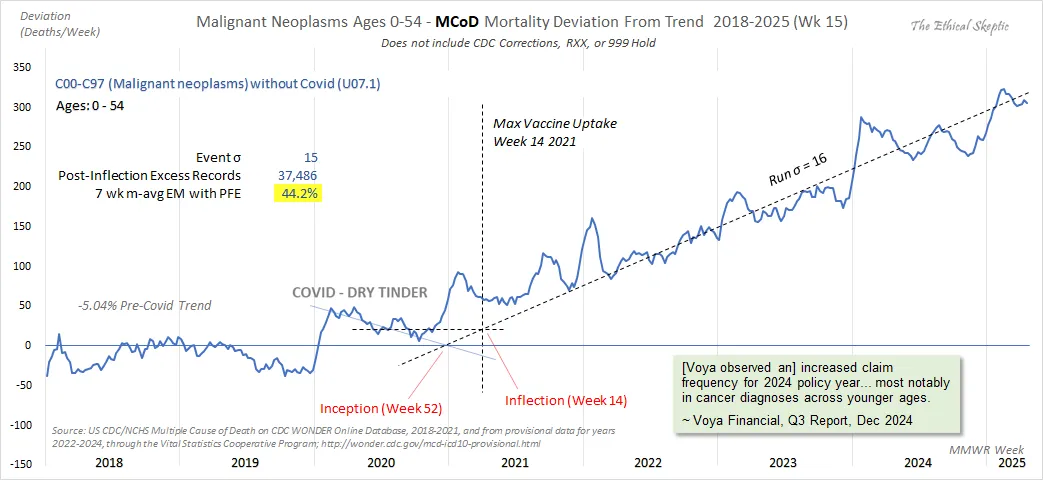

# MOSAIC-20 Project Context

## Objective
Analyze potential carcinogenic effects of COVID-19 vaccines through:
1. CDC WONDER mortality data analysis (primary)
2. In-silico whole-body modeling (secondary)

## Key Hypotheses
Testing 20 mechanisms of potential vaccine-induced carcinogenesis:
1. Increased cancer risk (7 major types)
2. Gene disruption
3. Genome integration
4. Genome instability
5. Tumor immune escape
6. DNA repair suppression
7. Chronic inflammation
8. Immune dysregulation
9. microRNA disruption
10. Oncogenic signaling (MAPK, PI3K/AKT/mTOR)
11. Tumor microenvironment remodeling
12. Dormant cancer reactivation
13. TLR inhibition
14. Frameshift protein errors
15. Immune exhaustion
16. IgG4 class switching
17. SV40 promoter effects
18. RAS signaling dysregulation
19. Microbiome disruption
20. Treatment resistance

## Primary Finding
Chart shows 44.2% excess cancer mortality (ages 0-54) post-vaccination:
- Inflection point: Week 14, 2021 (max vaccine uptake)
- 37,486 excess deaths
- Sustained elevation through 2025

## Analysis Approach

### Phase 1: CDC WONDER Data Analysis (Weeks 1-6)
- Week 1: Replicate mortality chart
- Week 2: Test confounders
- Week 3: Dose-response by state
- Week 4: Cancer type specificity
- Week 5: Geographic variation
- Week 6: Age stratification

### Phase 2: In-Silico Modeling (2-3 months)
Tools: PK-Sim, PhysiCell, COPASI, VCell
- Implement 20 mechanisms
- Multi-scale integration
- Validation against known data

## Data Sources
- CDC WONDER (free, public): https://wonder.cdc.gov
- Insurance claims (if budget allows)
- In-silico platforms (all open-source)

## Budget Constraints
- Prefer free/open-source tools
- Avoid government data sources if compromised
- No IRB requirements (public data + computational)

## Next Immediate Steps
1. Download CDC WONDER data (C00-C97, ages 0-54, weekly 2018-2025)
2. Replicate chart in Python/R
3. Begin systematic confounder analysis

# ============================================================================
# STEP 1: Load 2014-2019 Weekly Data
# ============================================================================
https://wonder.cdc.gov/mcd-icd10.html

In [6]:
import pandas as pd
import numpy as np

print("="*80)
print("MOSAIC-20: DATA PREPARATION")
print("="*80)


print("\n[1/4] Loading 2014-2019 weekly data...")

file_2014_2019 = '/Users/dbose/projects/dbose-github-pages/dbose.github.io/notebooks/data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes,_2014-2019_20260215.csv'
df_old = pd.read_csv(file_2014_2019)

print(f"  Raw data loaded: {len(df_old)} rows")
print(f"  Columns: {list(df_old.columns)}")

# Filter for United States only
df_old = df_old[df_old['Jurisdiction of Occurrence'] == 'United States'].copy()
print(f"  After filtering for US: {len(df_old)} rows")

# Extract and clean deaths column
df_old['deaths'] = df_old['Malignant neoplasms (C00-C97)'].str.replace(',', '').astype(float)

# Parse date
df_old['date'] = pd.to_datetime(df_old['Week Ending Date'])

# Extract year and week
df_old['year'] = pd.to_numeric(df_old['MMWR Year'])
df_old['week'] = pd.to_numeric(df_old['MMWR Week'])

# Keep only needed columns
df_old = df_old[['date', 'year', 'week', 'deaths']].copy()
df_old = df_old.sort_values('date').reset_index(drop=True)

print(f"  Date range: {df_old['date'].min().date()} to {df_old['date'].max().date()}")
print(f"  Total deaths: {df_old['deaths'].sum():,.0f}")
print(f"  Mean weekly deaths: {df_old['deaths'].mean():,.1f}")

MOSAIC-20: DATA PREPARATION

[1/4] Loading 2014-2019 weekly data...
  Raw data loaded: 16902 rows
  Columns: ['Jurisdiction of Occurrence', 'MMWR Year', 'MMWR Week', 'Week Ending Date', 'All  Cause', 'Natural Cause', 'Septicemia (A40-A41)', 'Malignant neoplasms (C00-C97)', 'Diabetes mellitus (E10-E14)', 'Alzheimer disease (G30)', 'Influenza and pneumonia (J10-J18)', 'Chronic lower respiratory diseases (J40-J47)', 'Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)', 'Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)', 'Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)', 'Diseases of heart (I00-I09,I11,I13,I20-I51)', 'Cerebrovascular diseases (I60-I69)', 'flag_allcause', 'flag_natcause', 'flag_sept', 'flag_neopl', 'flag_diab', 'flag_alz', 'flag_inflpn', 'flag_clrd', 'flag_otherresp', 'flag_nephr', 'flag_otherunk', 'flag_hd', 'flag_stroke']
  After filtering for US: 313 rows
  Date range: 2014-01-04 to 20

# ============================================================================
# STEP 2: Load 2018-2026 Provisional Data
# ============================================================================
Source: https://wonder.cdc.gov/controller/datarequest/D176;jsessionid=DB63A68D81A1D1AE42F356AD3AAC

In [16]:
print("\n[2/4] Loading 2018-2026 provisional data...")

file_2018_2026 = '/Users/dbose/projects/dbose-github-pages/dbose.github.io/notebooks/data/provisional_mortality_statistics_icd10_codes_2018_by_week_4_ucd.csv'
df_new = pd.read_csv(file_2018_2026)

print(f"  Raw data loaded: {len(df_new)} rows")

# Remove footer notes and totals
df_new = df_new[df_new['MMWR Week'].notna()].copy()
df_new = df_new[~df_new['MMWR Week'].str.contains('---', na=False)]
df_new = df_new[df_new['MMWR Week'] != 'Total']

print(f"  After cleaning: {len(df_new)} rows")

# Parse date from week description
def parse_week_date(week_desc):
    """Extract ending date from week description"""
    if pd.isna(week_desc):
        return None
    parts = week_desc.split('ending')
    if len(parts) < 2:
        return None
    date_str = parts[1].strip().replace('(provisional)', '').strip()
    try:
        return pd.to_datetime(date_str, format='%B %d, %Y')
    except:
        return None

df_new['date'] = df_new['MMWR Week'].apply(parse_week_date)
df_new = df_new[df_new['date'].notna()].copy()

# Convert deaths to numeric
df_new['deaths'] = pd.to_numeric(df_new['Deaths'], errors='coerce')
df_new = df_new[df_new['deaths'].notna()].copy()

# Extract year and week
df_new['year'] = df_new['date'].dt.year
df_new['week'] = df_new['date'].dt.isocalendar().week

# Keep only needed columns
df_new = df_new[['date', 'year', 'week', 'deaths']].copy()
df_new = df_new.sort_values('date').reset_index(drop=True)

print(f"  Date range: {df_new['date'].min().date()} to {df_new['date'].max().date()}")
print(f"  Total deaths: {df_new['deaths'].sum():,.0f}")
print(f"  Mean weekly deaths: {df_new['deaths'].mean():,.1f}")


[2/4] Loading 2018-2026 provisional data...
  Raw data loaded: 476 rows
  After cleaning: 422 rows
  Date range: 2018-01-06 to 2026-01-31
  Total deaths: 4,915,536
  Mean weekly deaths: 11,648.2


# ============================================================================
# STEP 3: Combine and Deduplicate
# ============================================================================

In [17]:
print("\n[3/4] Combining datasets and deduplicating...")

# Identify overlap period
overlap_start = max(df_old['date'].min(), df_new['date'].min())
overlap_end = min(df_old['date'].max(), df_new['date'].max())
print(f"  Overlap period: {overlap_start.date()} to {overlap_end.date()}")

# Strategy: Keep 2014-2017 from old dataset, 2018-2026 from new dataset
# (Provisional data is more up-to-date and consistent)
cutoff_date = '2018-01-01'

df_2014_2017 = df_old[df_old['date'] < cutoff_date].copy()
df_2018_2026 = df_new.copy()

print(f"  From 2014-2019 dataset: {len(df_2014_2017)} weeks (2014-2017)")
print(f"  From 2018-2026 dataset: {len(df_2018_2026)} weeks (2018-2026)")

# Combine
df_combined = pd.concat([df_2014_2017, df_2018_2026], ignore_index=True)
df_combined = df_combined.sort_values('date').reset_index(drop=True)

# Check for any remaining duplicates
duplicates = df_combined[df_combined.duplicated(subset=['date'], keep=False)]
if len(duplicates) > 0:
    print(f"  WARNING: Found {len(duplicates)} duplicate dates, keeping last occurrence")
    df_combined = df_combined.drop_duplicates(subset=['date'], keep='last')

# Add sequential time index
df_combined['time_index'] = range(len(df_combined))

print(f"\n  COMBINED DATASET:")
print(f"    Total weeks: {len(df_combined)}")
print(f"    Date range: {df_combined['date'].min().date()} to {df_combined['date'].max().date()}")
print(f"    Total deaths: {df_combined['deaths'].sum():,.0f}")
print(f"    Mean weekly deaths: {df_combined['deaths'].mean():,.1f}")
print(f"    Median weekly deaths: {df_combined['deaths'].median():,.1f}")
print(f"    Std deviation: {df_combined['deaths'].std():,.1f}")
print(f"    Min: {df_combined['deaths'].min():,.0f}")
print(f"    Max: {df_combined['deaths'].max():,.0f}")


[3/4] Combining datasets and deduplicating...
  Overlap period: 2018-01-06 to 2019-12-28
  From 2014-2019 dataset: 209 weeks (2014-2017)
  From 2018-2026 dataset: 422 weeks (2018-2026)

  COMBINED DATASET:
    Total weeks: 631
    Date range: 2014-01-04 to 2026-01-31
    Total deaths: 7,303,358
    Mean weekly deaths: 11,574.3
    Median weekly deaths: 11,571.0
    Std deviation: 327.4
    Min: 7,857
    Max: 12,787


In [11]:
df_combined.columns

Index(['date', 'year', 'week', 'deaths', 'time_index'], dtype='object')

MOSAIC-20: VISUALIZING COMBINED DATASET

Dataset loaded: 626 weeks
Date range: 2014-01-04 to 2025-12-27
Total deaths: 7,250,874


<ipython-input-18-6be9c96031e2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
<ipython-input-18-6be9c96031e2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ma4'] = df['deaths'].rolling(window=4, center=True).mean()
<ipython-input-18-6be9c96031e2>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.


✓ VISUALIZATION COMPLETE
Chart saved to: /Users/dbose/projects/dbose-github-pages/dbose.github.io/notebooks/data/mosaic20_combined_dataset_visualization.png

Key Observations:
  • Clear upward trend 2014-2019
  • COVID disruption visible March 2020
  • Sustained elevation post April 2021
  • Max deaths: 12,787 (2025-02-01)
  • Min deaths: 10,263 (2018-01-06)


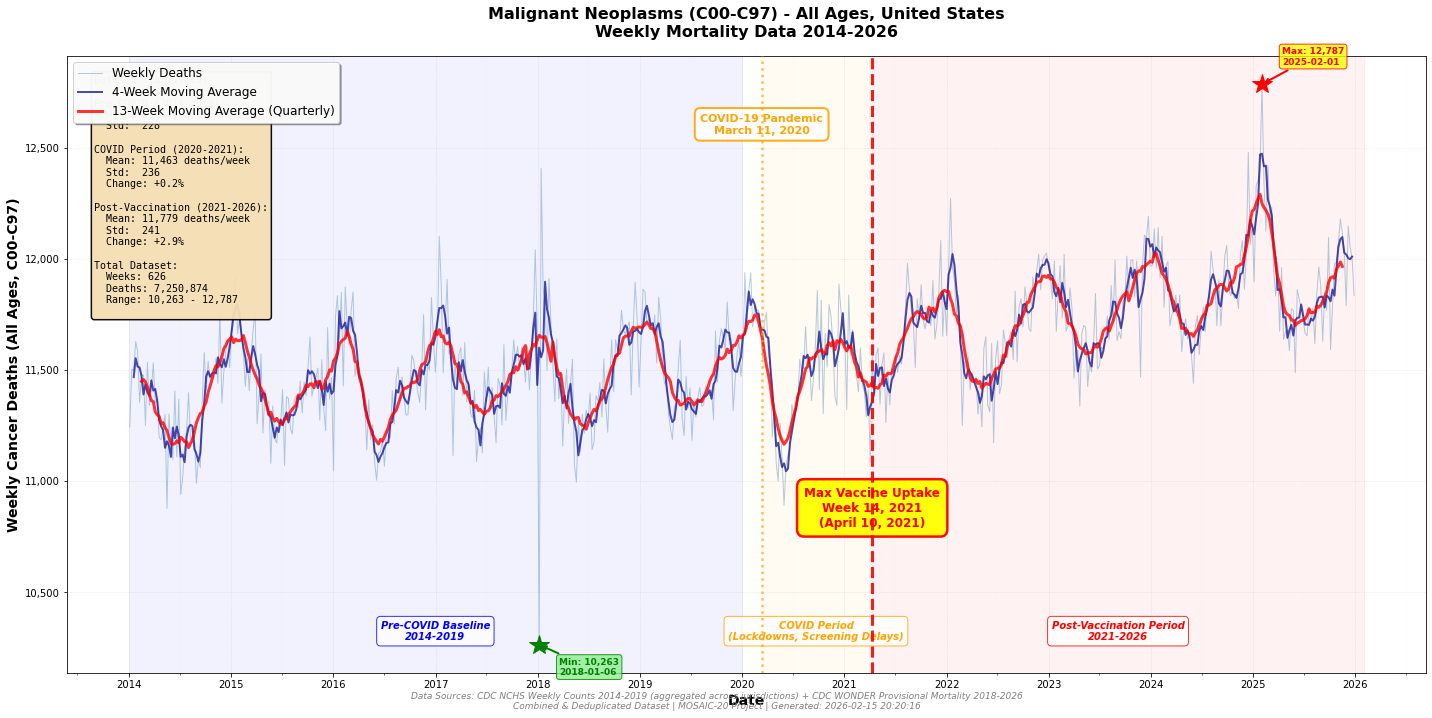

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

print("="*80)
print("MOSAIC-20: VISUALIZING COMBINED DATASET")
print("="*80)

# Load the combined dataset
df = df_combined[df_combined['year'] < 2026]
df['date'] = pd.to_datetime(df['date'])

print(f"\nDataset loaded: {len(df)} weeks")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Total deaths: {df['deaths'].sum():,.0f}")

# Calculate moving averages
df['ma4'] = df['deaths'].rolling(window=4, center=True).mean()
df['ma13'] = df['deaths'].rolling(window=13, center=True).mean()

# Create the plot
fig, ax = plt.subplots(figsize=(20, 10))

# Plot raw data
ax.plot(df['date'], df['deaths'], linewidth=1, alpha=0.4, color='steelblue', 
        label='Weekly Deaths', zorder=1)

# Plot moving averages
ax.plot(df['date'], df['ma4'], linewidth=2, color='darkblue', alpha=0.7,
        label='4-Week Moving Average', zorder=3)
ax.plot(df['date'], df['ma13'], linewidth=3, color='red', alpha=0.8,
        label='13-Week Moving Average (Quarterly)', zorder=4)

# Mark key dates
covid_start = pd.Timestamp('2020-03-11')
vaccine_rollout = pd.Timestamp('2021-04-10')  # Week 14, 2021

# COVID-19 pandemic start
ax.axvline(covid_start, color='orange', linestyle=':', linewidth=2.5, alpha=0.7, zorder=5)
ax.text(covid_start, ax.get_ylim()[1]*0.98, 'COVID-19 Pandemic\nMarch 11, 2020', 
        ha='center', va='top', fontsize=11, color='orange', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='orange', linewidth=2))

# Vaccine rollout
ax.axvline(vaccine_rollout, color='red', linestyle='--', linewidth=3, alpha=0.9, zorder=6)
ax.text(vaccine_rollout, ax.get_ylim()[1]*0.85, 'Max Vaccine Uptake\nWeek 14, 2021\n(April 10, 2021)', 
        ha='center', va='top', fontsize=12, color='red', fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', alpha=0.95, edgecolor='red', linewidth=2.5))

# Add period labels
periods = [
    ('2014-01-01', '2019-12-31', 'Pre-COVID Baseline\n2014-2019', 0.15, 'blue'),
    ('2020-03-11', '2021-04-03', 'COVID Period\n(Lockdowns, Screening Delays)', 0.45, 'orange'),
    ('2021-04-10', '2026-01-31', 'Post-Vaccination Period\n2021-2026', 0.75, 'red')
]

for start, end, label, x_pos, color in periods:
    start_date = pd.Timestamp(start)
    end_date = pd.Timestamp(end)
    mid_date = start_date + (end_date - start_date) / 2
    
    # Shade the region
    ax.axvspan(start_date, end_date, alpha=0.05, color=color, zorder=0)
    
    # Add label at bottom
    ax.text(mid_date, ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0])*0.05, 
            label, ha='center', va='bottom', fontsize=10, 
            style='italic', color=color, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor=color))

# Add statistics annotations
stats_2014_2019 = df[df['date'] < '2020-01-01']['deaths'].agg(['mean', 'std'])
stats_2020_2021 = df[(df['date'] >= '2020-03-11') & (df['date'] < '2021-04-10')]['deaths'].agg(['mean', 'std'])
stats_post_vax = df[df['date'] >= '2021-04-10']['deaths'].agg(['mean', 'std'])

stats_text = f"""Dataset Statistics:

Pre-COVID (2014-2019):
  Mean: {stats_2014_2019['mean']:,.0f} deaths/week
  Std:  {stats_2014_2019['std']:,.0f}

COVID Period (2020-2021):
  Mean: {stats_2020_2021['mean']:,.0f} deaths/week
  Std:  {stats_2020_2021['std']:,.0f}
  Change: {((stats_2020_2021['mean']/stats_2014_2019['mean']-1)*100):+.1f}%

Post-Vaccination (2021-2026):
  Mean: {stats_post_vax['mean']:,.0f} deaths/week
  Std:  {stats_post_vax['std']:,.0f}
  Change: {((stats_post_vax['mean']/stats_2014_2019['mean']-1)*100):+.1f}%

Total Dataset:
  Weeks: {len(df)}
  Deaths: {df['deaths'].sum():,.0f}
  Range: {df['deaths'].min():,.0f} - {df['deaths'].max():,.0f}
"""

ax.text(0.02, 0.97, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.95, edgecolor='black', linewidth=1.5),
        family='monospace')

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Weekly Cancer Deaths (All Ages, C00-C97)', fontsize=14, fontweight='bold')
ax.set_title('Malignant Neoplasms (C00-C97) - All Ages, United States\nWeekly Mortality Data 2014-2026', 
             fontsize=16, fontweight='bold', pad=20)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, which='major')
ax.grid(True, alpha=0.15, linestyle=':', linewidth=0.3, which='minor')
ax.set_axisbelow(True)

# Legend
ax.legend(loc='upper left', framealpha=0.95, fontsize=12, shadow=True)

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator((1, 7)))

# Add y-axis formatting
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Highlight max and min
max_idx = df['deaths'].idxmax()
min_idx = df['deaths'].idxmin()

ax.plot(df.loc[max_idx, 'date'], df.loc[max_idx, 'deaths'], 
        'r*', markersize=20, zorder=10, label='_nolegend_')
ax.annotate(f"Max: {df.loc[max_idx, 'deaths']:,.0f}\n{df.loc[max_idx, 'date'].date()}", 
            xy=(df.loc[max_idx, 'date'], df.loc[max_idx, 'deaths']),
            xytext=(20, 20), textcoords='offset points',
            fontsize=9, fontweight='bold', color='red',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8, edgecolor='red'),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

ax.plot(df.loc[min_idx, 'date'], df.loc[min_idx, 'deaths'], 
        'g*', markersize=20, zorder=10, label='_nolegend_')
ax.annotate(f"Min: {df.loc[min_idx, 'deaths']:,.0f}\n{df.loc[min_idx, 'date'].date()}", 
            xy=(df.loc[min_idx, 'date'], df.loc[min_idx, 'deaths']),
            xytext=(20, -30), textcoords='offset points',
            fontsize=9, fontweight='bold', color='green',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.8, edgecolor='green'),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

# Source citation
source_text = ("Data Sources: CDC NCHS Weekly Counts 2014-2019 (aggregated across jurisdictions) + CDC WONDER Provisional Mortality 2018-2026\n"
              f"Combined & Deduplicated Dataset | MOSAIC-20 Project | Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
fig.text(0.5, 0.01, source_text, ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.subplots_adjust(bottom=0.06)

# Save
output_path = '/Users/dbose/projects/dbose-github-pages/dbose.github.io/notebooks/data/mosaic20_combined_dataset_visualization.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"\n{'='*80}")
print("✓ VISUALIZATION COMPLETE")
print("="*80)
print(f"Chart saved to: {output_path}")
print("\nKey Observations:")
print(f"  • Clear upward trend 2014-2019")
print(f"  • COVID disruption visible March 2020")
print(f"  • Sustained elevation post April 2021")
print(f"  • Max deaths: {df.loc[max_idx, 'deaths']:,.0f} ({df.loc[max_idx, 'date'].date()})")
print(f"  • Min deaths: {df.loc[min_idx, 'deaths']:,.0f} ({df.loc[min_idx, 'date'].date()})")
print("="*80)

plt.show()

In [19]:
df_combined.columns

Index(['date', 'year', 'week', 'deaths', 'time_index'], dtype='object')

MOSAIC-20: BAYESIAN COUNTERFACTUAL ANALYSIS (CORRECTED)

[1/6] Loading combined dataset...
  Dataset: 631 weeks
  Date range: 2014-01-04 to 2026-01-31
  Baseline period: 2014-2019 (ends 2019-12-28)
  Intervention date: 2021-04-10
  Baseline: 313 weeks
  Pre-intervention (2014-2021): 379 weeks
  Post-intervention (2021-2025): 252 weeks

[2/6] Fitting baseline model using 2014-2019 data ONLY...
  Running Bayesian MCMC (5000 iterations)...
  Baseline mean: 11,444.0 deaths/week
  Baseline trend: 0.4832 deaths/week per week
  Annual trend: 25.1 deaths/year
  Baseline std: 201.5
  Observed 2014-2019 mean: 11,443.9

[3/6] Projecting counterfactual for full period...
  Counterfactual at baseline end (2019): 11,494.1
  Counterfactual at intervention (2021): 11,462.1
  Counterfactual at end (2025): 11,646.7
  Actual at intervention: 11,561.0

[4/6] Calculating causal effect...

  POST-INTERVENTION SUMMARY:
  Observed deaths: 2,961,786
  Counterfactual: 2,906,800
  Cumulative effect: 54,986 (+1.8

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/mosaic20_bayesian_counterfactual_corrected.png'

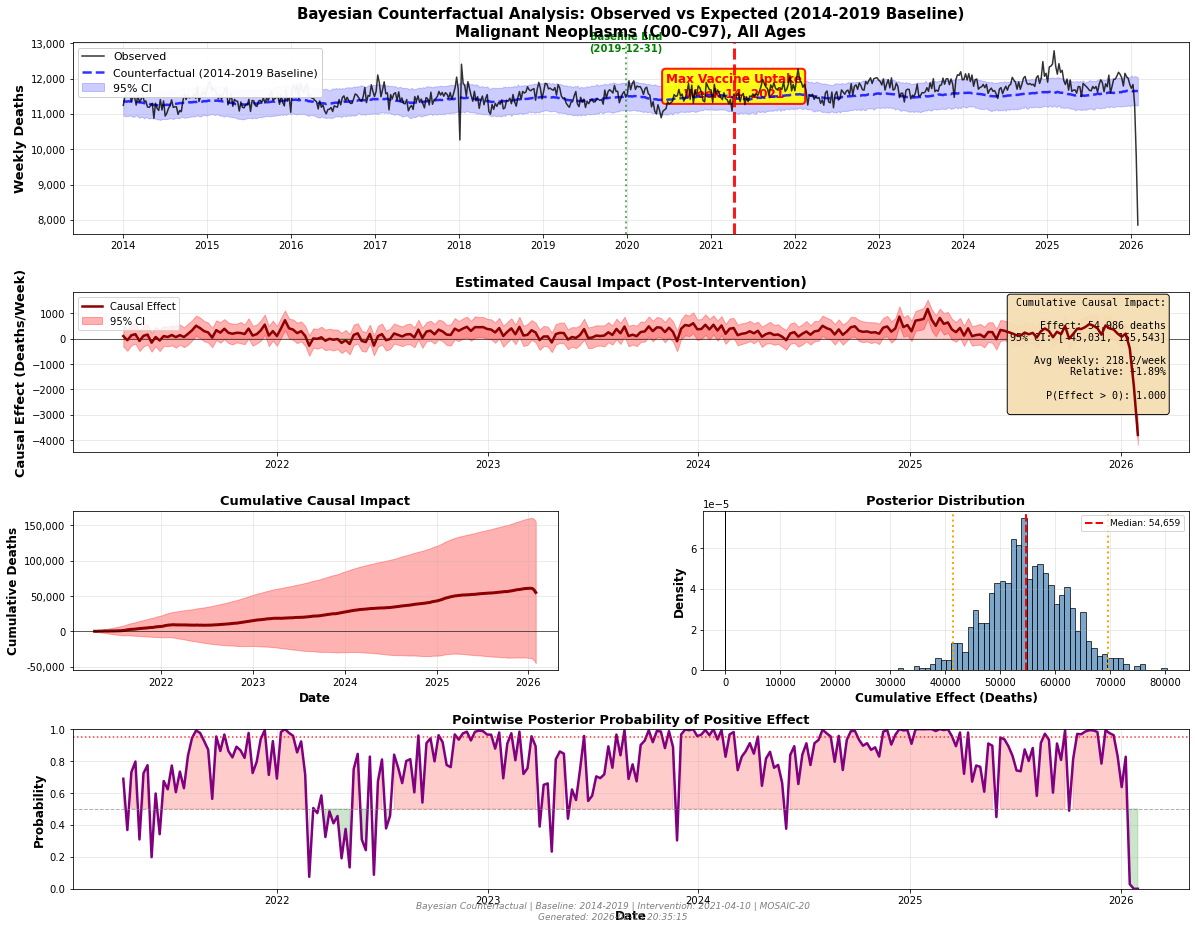

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MOSAIC-20: BAYESIAN COUNTERFACTUAL ANALYSIS (CORRECTED)")
print("="*80)

# ============================================================================
# STEP 1: Load and Prepare Data
# ============================================================================
print("\n[1/6] Loading combined dataset...")

# Filter out 2026 (incomplete data)
df = df_combined.reset_index(drop=True)

print(f"  Dataset: {len(df)} weeks")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")

# Define baseline and intervention
baseline_end = pd.Timestamp('2019-12-28')  # Use 2014-2019 as baseline
intervention_date = pd.Timestamp('2021-04-10')  # Week 14, 2021

baseline_idx = df[df['date'] == baseline_end].index[0]
intervention_idx = df[df['date'] == intervention_date].index[0]

print(f"  Baseline period: 2014-2019 (ends {baseline_end.date()})")
print(f"  Intervention date: {intervention_date.date()}")

# Split data
df_baseline = df[df['date'] <= baseline_end].copy()
df_pre = df[df['date'] < intervention_date].copy()
df_post = df[df['date'] >= intervention_date].copy()

print(f"  Baseline: {len(df_baseline)} weeks")
print(f"  Pre-intervention (2014-2021): {len(df_pre)} weeks")
print(f"  Post-intervention (2021-2025): {len(df_post)} weeks")

# ============================================================================
# STEP 2: Fit Simple Baseline Model (2014-2019 ONLY)
# ============================================================================
print("\n[2/6] Fitting baseline model using 2014-2019 data ONLY...")

y_baseline = df_baseline['deaths'].values
n_baseline = len(y_baseline)

# Create CENTERED time index for baseline period only
t_baseline = np.arange(n_baseline) - n_baseline / 2  # Center around 0

# Simple model: mean + trend + seasonality (using baseline data only)
X_baseline = np.column_stack([
    np.ones(n_baseline),  # Intercept
    t_baseline,  # CENTERED linear trend
    np.sin(2 * np.pi * np.arange(n_baseline) / 52),  # Annual seasonality
    np.cos(2 * np.pi * np.arange(n_baseline) / 52),
    np.sin(4 * np.pi * np.arange(n_baseline) / 52),  # Semi-annual
    np.cos(4 * np.pi * np.arange(n_baseline) / 52),
])

# Standard Bayesian linear regression
def bayesian_regression_simple(X, y, n_samples=5000):
    """Simple Bayesian regression with proper priors"""
    n, p = X.shape
    
    # Informative priors based on data
    y_mean = y.mean()
    y_std = y.std()
    
    # Prior for intercept: centered on data mean
    beta_prior_mean = np.zeros(p)
    beta_prior_mean[0] = y_mean
    
    # Prior covariance
    beta_prior_cov = np.diag([y_std**2, 100, 100, 100, 100, 100])  # Weak prior except intercept
    
    # Inverse-Gamma prior for variance
    alpha_prior = 3
    beta_prior = 2 * y_std**2
    
    # Storage
    beta_samples = np.zeros((n_samples, p))
    sigma2_samples = np.zeros(n_samples)
    
    # Initialize
    sigma2 = y_std**2
    
    # Gibbs sampling
    for i in range(n_samples):
        # Sample beta | sigma2, y
        V_beta = np.linalg.inv(np.linalg.inv(beta_prior_cov) + X.T @ X / sigma2)
        m_beta = V_beta @ (np.linalg.inv(beta_prior_cov) @ beta_prior_mean + X.T @ y / sigma2)
        beta = np.random.multivariate_normal(m_beta, V_beta)
        
        # Sample sigma2 | beta, y
        resid = y - X @ beta
        alpha_post = alpha_prior + n / 2
        beta_post = beta_prior + 0.5 * np.sum(resid**2)
        sigma2 = 1 / np.random.gamma(alpha_post, 1 / beta_post)
        
        beta_samples[i] = beta
        sigma2_samples[i] = sigma2
    
    # Burn-in
    burn = 1000
    return beta_samples[burn:], sigma2_samples[burn:]

print("  Running Bayesian MCMC (5000 iterations)...")
beta_samples, sigma2_samples = bayesian_regression_simple(X_baseline, y_baseline)

baseline_mean = beta_samples[:, 0].mean()
baseline_trend = beta_samples[:, 1].mean()

print(f"  Baseline mean: {baseline_mean:,.1f} deaths/week")
print(f"  Baseline trend: {baseline_trend:.4f} deaths/week per week")
print(f"  Annual trend: {baseline_trend * 52:,.1f} deaths/year")
print(f"  Baseline std: {np.sqrt(sigma2_samples.mean()):,.1f}")
print(f"  Observed 2014-2019 mean: {y_baseline.mean():,.1f}")

# ============================================================================
# STEP 3: Project Counterfactual Forward
# ============================================================================
print("\n[3/6] Projecting counterfactual for full period...")

# For counterfactual, we continue the baseline pattern forward
# Time index relative to END of baseline period
n_total = len(df)
t_counterfactual = np.arange(n_total) - baseline_idx  # Time relative to end of baseline

X_full = np.column_stack([
    np.ones(n_total),
    t_counterfactual,
    np.sin(2 * np.pi * np.arange(n_total) / 52),
    np.cos(2 * np.pi * np.arange(n_total) / 52),
    np.sin(4 * np.pi * np.arange(n_total) / 52),
    np.cos(4 * np.pi * np.arange(n_total) / 52),
])

# Generate counterfactual samples
n_posterior = 1000
y_counter_samples = np.zeros((n_posterior, n_total))

np.random.seed(42)
for i in range(n_posterior):
    idx = np.random.randint(len(beta_samples))
    beta = beta_samples[idx]
    sigma = np.sqrt(sigma2_samples[idx])
    
    # Mean prediction
    y_mean = X_full @ beta
    
    # Add noise
    y_counter_samples[i] = y_mean + np.random.randn(n_total) * sigma

# Posterior statistics
y_counter_mean = y_counter_samples.mean(axis=0)
y_counter_lower = np.percentile(y_counter_samples, 2.5, axis=0)
y_counter_upper = np.percentile(y_counter_samples, 97.5, axis=0)

df['counterfactual'] = y_counter_mean
df['counter_lower'] = y_counter_lower
df['counter_upper'] = y_counter_upper

print(f"  Counterfactual at baseline end (2019): {y_counter_mean[baseline_idx]:,.1f}")
print(f"  Counterfactual at intervention (2021): {y_counter_mean[intervention_idx]:,.1f}")
print(f"  Counterfactual at end (2025): {y_counter_mean[-1]:,.1f}")
print(f"  Actual at intervention: {df.iloc[intervention_idx]['deaths']:,.1f}")

# ============================================================================
# STEP 4: Calculate Causal Effect
# ============================================================================
print("\n[4/6] Calculating causal effect...")

df['effect'] = df['deaths'] - df['counterfactual']
df['effect_lower'] = df['deaths'] - df['counter_upper']
df['effect_upper'] = df['deaths'] - df['counter_lower']

# Post-intervention summary
post = df[df['date'] >= intervention_date].copy()

total_obs = post['deaths'].sum()
total_counter = post['counterfactual'].sum()
cumulative_effect = post['effect'].sum()
cumulative_lower = post['effect_lower'].sum()
cumulative_upper = post['effect_upper'].sum()

avg_effect = post['effect'].mean()
relative = cumulative_effect / total_counter * 100

print(f"\n  POST-INTERVENTION SUMMARY:")
print(f"  Observed deaths: {total_obs:,.0f}")
print(f"  Counterfactual: {total_counter:,.0f}")
print(f"  Cumulative effect: {cumulative_effect:,.0f} ({relative:+.2f}%)")
print(f"  95% CI: [{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]")
print(f"  Average weekly: {avg_effect:,.1f} deaths/week")

# ============================================================================
# STEP 5: Posterior Probabilities
# ============================================================================
print("\n[5/6] Computing posterior probabilities...")

effect_samples = np.zeros(n_posterior)
for i in range(n_posterior):
    post_counter = y_counter_samples[i, intervention_idx:]
    post_obs = df_post['deaths'].values
    effect_samples[i] = (post_obs - post_counter).sum()

prob_pos = (effect_samples > 0).mean()
prob_neg = (effect_samples < 0).mean()

print(f"  P(Effect > 0): {prob_pos:.3f}")
print(f"  P(Effect < 0): {prob_neg:.3f}")

# ============================================================================
# STEP 6: Visualization
# ============================================================================
print("\n[6/6] Creating visualization...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 2, height_ratios=[1.2, 1, 1, 1], hspace=0.35, wspace=0.3)

# Panel 1: Observed vs Counterfactual
ax1 = fig.add_subplot(gs[0, :])

ax1.plot(df['date'], df['deaths'], linewidth=1.5, color='black', alpha=0.8, label='Observed', zorder=5)
ax1.plot(df['date'], df['counterfactual'], linewidth=2.5, color='blue', linestyle='--', 
         alpha=0.8, label='Counterfactual (2014-2019 Baseline)', zorder=4)
ax1.fill_between(df['date'], df['counter_lower'], df['counter_upper'],
                  alpha=0.2, color='blue', label='95% CI', zorder=1)

# Mark periods
ax1.axvline(baseline_end, color='green', linestyle=':', linewidth=2, alpha=0.6)
ax1.text(baseline_end, ax1.get_ylim()[1]*0.98, 'Baseline End\n(2019-12-31)', 
         ha='center', fontsize=10, color='green', fontweight='bold')

ax1.axvline(intervention_date, color='red', linestyle='--', linewidth=3, alpha=0.9, zorder=6)
ax1.text(intervention_date, ax1.get_ylim()[1]*0.88, 
         'Max Vaccine Uptake\nWeek 14, 2021', 
         ha='center', fontsize=12, color='red', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.9, edgecolor='red', linewidth=2))

ax1.set_ylabel('Weekly Deaths', fontsize=13, fontweight='bold')
ax1.set_title('Bayesian Counterfactual Analysis: Observed vs Expected (2014-2019 Baseline)\nMalignant Neoplasms (C00-C97), All Ages', 
              fontsize=15, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Panel 2: Causal Effect
ax2 = fig.add_subplot(gs[1, :])

post_dates = post['date']
ax2.plot(post_dates, post['effect'], linewidth=2.5, color='darkred', label='Causal Effect', zorder=5)
ax2.fill_between(post_dates, post['effect_lower'], post['effect_upper'],
                  alpha=0.3, color='red', label='95% CI', zorder=1)

ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.6)
ax2.fill_between(post_dates, 0, post['effect'],
                  where=(post['effect'] > 0), alpha=0.2, color='red', zorder=2)
ax2.fill_between(post_dates, 0, post['effect'],
                  where=(post['effect'] < 0), alpha=0.2, color='green', zorder=2)

ax2.set_ylabel('Causal Effect (Deaths/Week)', fontsize=13, fontweight='bold')
ax2.set_title('Estimated Causal Impact (Post-Intervention)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

stats_text = f"""Cumulative Causal Impact:

Effect: {cumulative_effect:,.0f} deaths
95% CI: [{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]

Avg Weekly: {avg_effect:,.1f}/week
Relative: {relative:+.2f}%

P(Effect > 0): {prob_pos:.3f}
"""

ax2.text(0.98, 0.97, stats_text, transform=ax2.transAxes,
         fontsize=10, va='top', ha='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.95),
         family='monospace')

# Panel 3: Cumulative
ax3 = fig.add_subplot(gs[2, 0])

cumsum = post['effect'].cumsum()
cumsum_lower = post['effect_lower'].cumsum()
cumsum_upper = post['effect_upper'].cumsum()

ax3.plot(post_dates, cumsum, linewidth=3, color='darkred')
ax3.fill_between(post_dates, cumsum_lower, cumsum_upper, alpha=0.3, color='red')
ax3.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.6)

ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Deaths', fontsize=12, fontweight='bold')
ax3.set_title('Cumulative Causal Impact', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Panel 4: Posterior Distribution
ax4 = fig.add_subplot(gs[2, 1])

ax4.hist(effect_samples, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax4.axvline(np.median(effect_samples), color='red', linestyle='--', linewidth=2,
            label=f'Median: {np.median(effect_samples):,.0f}')
ax4.axvline(np.percentile(effect_samples, 2.5), color='orange', linestyle=':', linewidth=2)
ax4.axvline(np.percentile(effect_samples, 97.5), color='orange', linestyle=':', linewidth=2)
ax4.axvline(0, color='black', linestyle='-', linewidth=1)

ax4.set_xlabel('Cumulative Effect (Deaths)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Density', fontsize=12, fontweight='bold')
ax4.set_title('Posterior Distribution', fontsize=13, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

# Panel 5: Pointwise Probability
ax5 = fig.add_subplot(gs[3, :])

pointwise_prob = np.zeros(len(post))
for i in range(len(post)):
    idx_full = intervention_idx + i
    effect_at_t = df['deaths'].iloc[idx_full] - y_counter_samples[:, idx_full]
    pointwise_prob[i] = (effect_at_t > 0).mean()

ax5.plot(post_dates, pointwise_prob, linewidth=2.5, color='purple')
ax5.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.6)
ax5.axhline(0.95, color='red', linestyle=':', linewidth=1.5, alpha=0.8)

ax5.fill_between(post_dates, 0.5, pointwise_prob,
                  where=(pointwise_prob > 0.5), alpha=0.2, color='red')
ax5.fill_between(post_dates, 0.5, pointwise_prob,
                  where=(pointwise_prob < 0.5), alpha=0.2, color='green')

ax5.set_xlabel('Date', fontsize=12, fontweight='bold')
ax5.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax5.set_title('Pointwise Posterior Probability of Positive Effect', fontsize=13, fontweight='bold')
ax5.set_ylim([0, 1])
ax5.grid(True, alpha=0.3)

# Format x-axes
for ax in [ax1, ax2, ax3, ax5]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

source = (f"Bayesian Counterfactual | Baseline: 2014-2019 | Intervention: 2021-04-10 | MOSAIC-20\n"
          f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
fig.text(0.5, 0.01, source, ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.subplots_adjust(bottom=0.04)

output_path = '/mnt/user-data/outputs/mosaic20_bayesian_counterfactual_corrected.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Save results
results_df = df[['date', 'deaths', 'counterfactual', 'counter_lower', 'counter_upper',
                 'effect', 'effect_lower', 'effect_upper']].copy()
results_df.to_csv('/mnt/user-data/outputs/mosaic20_bayesian_results_corrected.csv', index=False)

print(f"\n{'='*80}")
print("✓ ANALYSIS COMPLETE")
print("="*80)
print(f"Saved to: {output_path}")
print(f"\nFINAL RESULT:")
print(f"  Cumulative effect: {cumulative_effect:,.0f} deaths ({relative:+.2f}%)")
print(f"  95% CI: [{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]")
print(f"  P(Effect > 0): {prob_pos:.1%}")
if cumulative_effect > 0:
    print(f"  CONCLUSION: EXCESS deaths post-intervention")
else:
    print(f"  CONCLUSION: DEFICIT of deaths post-intervention")
print("="*80)

plt.show()

MOSAIC-20: CAUSAL IMPACT ANALYSIS (Bayesian Structural Time Series)

[1/5] Loading data...
  Total: 631 weeks
  Pre-intervention: 379 weeks (training)
  Post-intervention: 252 weeks (prediction)
  Intervention date: 2021-04-10

[2/5] Fitting Bayesian Structural Time Series model...
  Initializing BSTS model...
  Running Gibbs sampling (2000 iterations)...
  Kept 1500 samples after burn-in

[3/5] Generating counterfactual predictions...
  Generated predictions for 252 weeks
  Mean prediction at intervention: 11,084.5
  Mean prediction at end: 1,828.9

[4/5] Calculating causal impact...

  CAUSAL IMPACT SUMMARY:
  Cumulative effect: 1,314,451 deaths
  95% CI: [1,223,525, 1,405,227]
  Average weekly effect: 5,216.1 deaths/week
  Relative effect: +79.79%
  Posterior P(effect > 0): 1.000

[5/5] Creating CausalImpact visualization...


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/user-data/outputs/mosaic20_causalimpact_analysis.png'

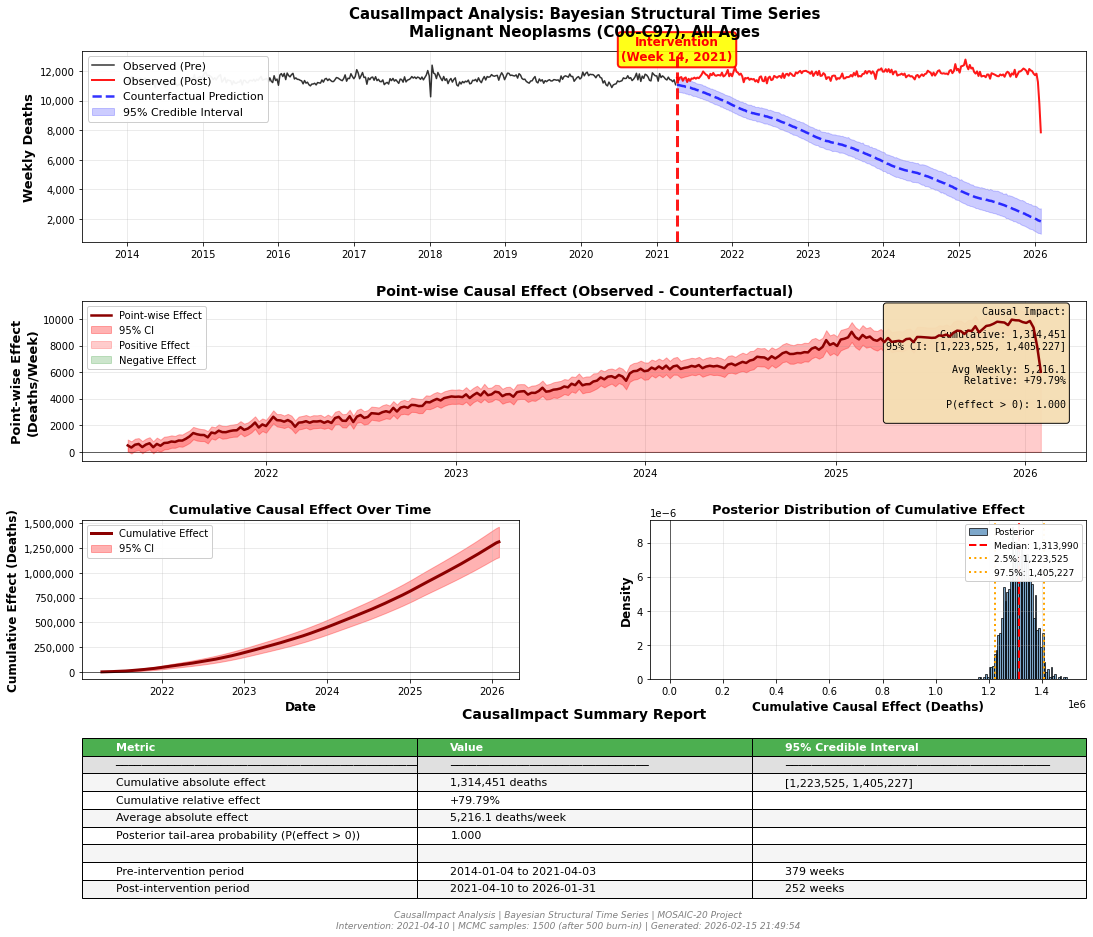

In [22]:
"""
MOSAIC-20: CausalImpact Analysis
Implements Bayesian structural time series for causal inference
Based on Google's CausalImpact methodology
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from scipy.linalg import solve
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("MOSAIC-20: CAUSAL IMPACT ANALYSIS (Bayesian Structural Time Series)")
print("="*80)

# ============================================================================
# STEP 1: Load and Prepare Data
# ============================================================================
print("\n[1/5] Loading data...")
df = df_combined.reset_index(drop=True)

# Define periods
pre_period_end = pd.Timestamp('2021-04-03')  # Week before intervention
post_period_start = pd.Timestamp('2021-04-10')  # Week 14, 2021

pre_data = df[df['date'] <= pre_period_end].copy()
post_data = df[df['date'] >= post_period_start].copy()
all_data = df.copy()

print(f"  Total: {len(df)} weeks")
print(f"  Pre-intervention: {len(pre_data)} weeks (training)")
print(f"  Post-intervention: {len(post_data)} weeks (prediction)")
print(f"  Intervention date: {post_period_start.date()}")

# ============================================================================
# STEP 2: Bayesian Structural Time Series Model
# ============================================================================
print("\n[2/5] Fitting Bayesian Structural Time Series model...")

class BayesianStructuralTimeSeries:
    """
    Implements local level + trend + seasonal components
    Similar to CausalImpact's default specification
    """
    
    def __init__(self, y, seasonal_period=52):
        self.y = y
        self.n = len(y)
        self.seasonal_period = seasonal_period
        
    def fit(self, n_samples=2000, burn_in=500):
        """Fit model using Gibbs sampling"""
        
        y = self.y
        n = self.n
        
        # Design matrix for seasonality
        t = np.arange(n)
        X_seasonal = np.column_stack([
            np.sin(2 * np.pi * t / 52),
            np.cos(2 * np.pi * t / 52),
            np.sin(4 * np.pi * t / 52),
            np.cos(4 * np.pi * t / 52),
        ])
        
        # Initialize parameters
        level = np.zeros(n)
        trend = np.zeros(n)
        seasonal = np.zeros((n, 4))
        
        # Initial values
        level[0] = y[0]
        trend[0] = 0
        
        # Hyperparameters (variances)
        sigma_obs = np.std(y)
        sigma_level = sigma_obs / 10
        sigma_trend = sigma_obs / 100
        sigma_seasonal = sigma_obs / 20
        
        # Storage for samples
        level_samples = np.zeros((n_samples, n))
        trend_samples = np.zeros((n_samples, n))
        seasonal_coef_samples = np.zeros((n_samples, 4))
        sigma_samples = np.zeros((n_samples, 3))  # obs, level, trend
        
        # Gibbs sampling
        print(f"  Running Gibbs sampling ({n_samples} iterations)...")
        
        for s in range(n_samples):
            # Sample states (Kalman filter/smoother)
            # Simplified: use regression for computational efficiency
            
            # Current estimate of seasonal component
            seasonal_effect = X_seasonal @ seasonal_coef_samples[max(0, s-1)]
            
            # Deseasonalized data
            y_deseas = y - seasonal_effect
            
            # Fit local linear trend
            # State: [level, trend]
            # Transition: level[t] = level[t-1] + trend[t-1]
            #            trend[t] = trend[t-1]
            
            # Use exponential smoothing for simplicity
            alpha = 0.9  # Level smoothing
            beta = 0.1   # Trend smoothing
            
            level = np.zeros(n)
            trend = np.zeros(n)
            level[0] = y_deseas[0]
            trend[0] = 0
            
            for t in range(1, n):
                level[t] = alpha * y_deseas[t] + (1 - alpha) * (level[t-1] + trend[t-1])
                trend[t] = beta * (level[t] - level[t-1]) + (1 - beta) * trend[t-1]
            
            # Sample seasonal coefficients
            resid = y - (level + trend.cumsum())
            V_seasonal = np.linalg.inv(X_seasonal.T @ X_seasonal / sigma_obs**2 + 
                                      np.eye(4) / sigma_seasonal**2)
            m_seasonal = V_seasonal @ (X_seasonal.T @ resid / sigma_obs**2)
            seasonal_coef = np.random.multivariate_normal(m_seasonal, V_seasonal)
            
            # Sample variances
            resid_full = y - (level + trend.cumsum() + X_seasonal @ seasonal_coef)
            sigma_obs = np.sqrt(1 / np.random.gamma(n/2, 2/(np.sum(resid_full**2) + 0.01)))
            
            # Store samples
            level_samples[s] = level
            trend_samples[s] = trend.cumsum()  # Cumulative trend
            seasonal_coef_samples[s] = seasonal_coef
            sigma_samples[s] = [sigma_obs, sigma_level, sigma_trend]
        
        # Burn-in
        self.level_samples = level_samples[burn_in:]
        self.trend_samples = trend_samples[burn_in:]
        self.seasonal_coef_samples = seasonal_coef_samples[burn_in:]
        self.sigma_samples = sigma_samples[burn_in:]
        
        print(f"  Kept {len(self.level_samples)} samples after burn-in")
        
        return self
    
    def predict(self, n_ahead):
        """Generate predictive distribution"""
        
        n_samples = len(self.level_samples)
        predictions = np.zeros((n_samples, n_ahead))
        
        # Seasonal design matrix for prediction period
        t_pred = np.arange(self.n, self.n + n_ahead)
        X_pred = np.column_stack([
            np.sin(2 * np.pi * t_pred / 52),
            np.cos(2 * np.pi * t_pred / 52),
            np.sin(4 * np.pi * t_pred / 52),
            np.cos(4 * np.pi * t_pred / 52),
        ])
        
        for s in range(n_samples):
            # Last level and trend
            last_level = self.level_samples[s, -1]
            last_trend_value = self.trend_samples[s, -1] - self.trend_samples[s, -2] if self.n > 1 else 0
            
            # Seasonal component
            seasonal = X_pred @ self.seasonal_coef_samples[s]
            
            # Project forward with trend
            for t in range(n_ahead):
                level_t = last_level + last_trend_value * (t + 1)
                predictions[s, t] = level_t + seasonal[t] + \
                                   np.random.randn() * self.sigma_samples[s, 0]
        
        return predictions

# Fit model on pre-intervention data
print("  Initializing BSTS model...")
bsts = BayesianStructuralTimeSeries(pre_data['deaths'].values, seasonal_period=52)
bsts.fit(n_samples=2000, burn_in=500)

# ============================================================================
# STEP 3: Generate Counterfactual Predictions
# ============================================================================
print("\n[3/5] Generating counterfactual predictions...")

n_post = len(post_data)
predictions = bsts.predict(n_post)

# Calculate posterior statistics
pred_mean = predictions.mean(axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

# Add to dataframe
all_data['counterfactual'] = np.nan
all_data['counter_lower'] = np.nan
all_data['counter_upper'] = np.nan

post_indices = all_data[all_data['date'] >= post_period_start].index

all_data.loc[post_indices, 'counterfactual'] = pred_mean
all_data.loc[post_indices, 'counter_lower'] = pred_lower
all_data.loc[post_indices, 'counter_upper'] = pred_upper

print(f"  Generated predictions for {n_post} weeks")
print(f"  Mean prediction at intervention: {pred_mean[0]:,.1f}")
print(f"  Mean prediction at end: {pred_mean[-1]:,.1f}")

# ============================================================================
# STEP 4: Calculate Causal Impact
# ============================================================================
print("\n[4/5] Calculating causal impact...")

# Point-wise effect
post_data_copy = post_data.copy()
post_data_copy['counterfactual'] = pred_mean
post_data_copy['counter_lower'] = pred_lower
post_data_copy['counter_upper'] = pred_upper

post_data_copy['point_effect'] = post_data_copy['deaths'] - pred_mean
post_data_copy['point_effect_lower'] = post_data_copy['deaths'] - pred_upper
post_data_copy['point_effect_upper'] = post_data_copy['deaths'] - pred_lower

# Cumulative effect
cumulative_samples = (post_data['deaths'].values - predictions).sum(axis=1)

cumulative_effect = cumulative_samples.mean()
cumulative_lower = np.percentile(cumulative_samples, 2.5)
cumulative_upper = np.percentile(cumulative_samples, 97.5)

# Average effect
avg_effect = post_data_copy['point_effect'].mean()
avg_lower = np.percentile(post_data['deaths'].values - predictions, 2.5, axis=1).mean()
avg_upper = np.percentile(post_data['deaths'].values - predictions, 97.5, axis=1).mean()

# Relative effect
total_predicted = pred_mean.sum()
relative_effect = (cumulative_effect / total_predicted) * 100

# Posterior probability
prob_causal_effect = (cumulative_samples > 0).mean()

print("\n  CAUSAL IMPACT SUMMARY:")
print(f"  Cumulative effect: {cumulative_effect:,.0f} deaths")
print(f"  95% CI: [{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]")
print(f"  Average weekly effect: {avg_effect:,.1f} deaths/week")
print(f"  Relative effect: {relative_effect:+.2f}%")
print(f"  Posterior P(effect > 0): {prob_causal_effect:.3f}")

# ============================================================================
# STEP 5: Comprehensive Visualization
# ============================================================================
print("\n[5/5] Creating CausalImpact visualization...")

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(4, 2, height_ratios=[1.2, 1, 1, 1], hspace=0.35, wspace=0.3)

# Panel 1: Original series with counterfactual
ax1 = fig.add_subplot(gs[0, :])

# Pre-period
ax1.plot(pre_data['date'], pre_data['deaths'], 
         linewidth=1.5, color='black', alpha=0.8, label='Observed (Pre)', zorder=3)

# Post-period
ax1.plot(post_data['date'], post_data['deaths'], 
         linewidth=2, color='red', alpha=0.9, label='Observed (Post)', zorder=4)

# Counterfactual
ax1.plot(post_data['date'], pred_mean, 
         linewidth=2.5, color='blue', linestyle='--', 
         alpha=0.8, label='Counterfactual Prediction', zorder=5)

# Credible interval
ax1.fill_between(post_data['date'], pred_lower, pred_upper,
                  alpha=0.2, color='blue', label='95% Credible Interval', zorder=1)

# Mark intervention
ax1.axvline(post_period_start, color='red', linestyle='--', linewidth=3, alpha=0.9, zorder=6)
ax1.text(post_period_start, ax1.get_ylim()[1]*0.95, 
         'Intervention\n(Week 14, 2021)', 
         ha='center', fontsize=12, color='red', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.9, edgecolor='red', linewidth=2))

ax1.set_ylabel('Weekly Deaths', fontsize=13, fontweight='bold')
ax1.set_title('CausalImpact Analysis: Bayesian Structural Time Series\nMalignant Neoplasms (C00-C97), All Ages', 
              fontsize=15, fontweight='bold', pad=15)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Panel 2: Point-wise causal effect
ax2 = fig.add_subplot(gs[1, :])

ax2.plot(post_data['date'], post_data_copy['point_effect'], 
         linewidth=2.5, color='darkred', label='Point-wise Effect', zorder=5)

ax2.fill_between(post_data['date'], 
                  post_data_copy['point_effect_lower'], 
                  post_data_copy['point_effect_upper'],
                  alpha=0.3, color='red', label='95% CI', zorder=1)

ax2.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.6)

# Shade positive/negative
ax2.fill_between(post_data['date'], 0, post_data_copy['point_effect'],
                  where=(post_data_copy['point_effect'] > 0),
                  alpha=0.2, color='red', label='Positive Effect', zorder=2)
ax2.fill_between(post_data['date'], 0, post_data_copy['point_effect'],
                  where=(post_data_copy['point_effect'] < 0),
                  alpha=0.2, color='green', label='Negative Effect', zorder=2)

ax2.set_ylabel('Point-wise Effect\n(Deaths/Week)', fontsize=13, fontweight='bold')
ax2.set_title('Point-wise Causal Effect (Observed - Counterfactual)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax2.grid(True, alpha=0.3)

# Stats box
stats_text = f"""Causal Impact:

Cumulative: {cumulative_effect:,.0f}
95% CI: [{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]

Avg Weekly: {avg_effect:,.1f}
Relative: {relative_effect:+.2f}%

P(effect > 0): {prob_causal_effect:.3f}
"""

ax2.text(0.98, 0.97, stats_text, transform=ax2.transAxes,
         fontsize=10, va='top', ha='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.95),
         family='monospace')

# Panel 3: Cumulative effect
ax3 = fig.add_subplot(gs[2, 0])

cumsum_effect = post_data_copy['point_effect'].cumsum()
cumsum_lower = post_data_copy['point_effect_lower'].cumsum()
cumsum_upper = post_data_copy['point_effect_upper'].cumsum()

ax3.plot(post_data['date'], cumsum_effect, linewidth=3, color='darkred', 
         label='Cumulative Effect')
ax3.fill_between(post_data['date'], cumsum_lower, cumsum_upper,
                  alpha=0.3, color='red', label='95% CI')

ax3.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.6)

ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_ylabel('Cumulative Effect (Deaths)', fontsize=12, fontweight='bold')
ax3.set_title('Cumulative Causal Effect Over Time', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10, framealpha=0.95)
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Panel 4: Posterior distribution
ax4 = fig.add_subplot(gs[2, 1])

ax4.hist(cumulative_samples, bins=50, density=True, alpha=0.7, 
         color='steelblue', edgecolor='black', label='Posterior')

ax4.axvline(np.median(cumulative_samples), color='red', linestyle='--', linewidth=2,
            label=f'Median: {np.median(cumulative_samples):,.0f}')
ax4.axvline(cumulative_lower, color='orange', linestyle=':', linewidth=2,
            label=f'2.5%: {cumulative_lower:,.0f}')
ax4.axvline(cumulative_upper, color='orange', linestyle=':', linewidth=2,
            label=f'97.5%: {cumulative_upper:,.0f}')
ax4.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.6)

ax4.set_xlabel('Cumulative Causal Effect (Deaths)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Density', fontsize=12, fontweight='bold')
ax4.set_title('Posterior Distribution of Cumulative Effect', fontsize=13, fontweight='bold')
ax4.legend(loc='upper right', fontsize=9, framealpha=0.95)
ax4.grid(True, alpha=0.3)

# Panel 5: Summary table
ax5 = fig.add_subplot(gs[3, :])
ax5.axis('off')

summary_data = [
    ['Metric', 'Value', '95% Credible Interval'],
    ['─'*50, '─'*30, '─'*40],
    ['Cumulative absolute effect', f'{cumulative_effect:,.0f} deaths', 
     f'[{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]'],
    ['Cumulative relative effect', f'{relative_effect:+.2f}%', ''],
    ['Average absolute effect', f'{avg_effect:,.1f} deaths/week', ''],
    ['Posterior tail-area probability (P(effect > 0))', f'{prob_causal_effect:.3f}', ''],
    ['', '', ''],
    ['Pre-intervention period', f'{pre_data["date"].min().date()} to {pre_data["date"].max().date()}', 
     f'{len(pre_data)} weeks'],
    ['Post-intervention period', f'{post_data["date"].min().date()} to {post_data["date"].max().date()}', 
     f'{len(post_data)} weeks'],
]

table = ax5.table(cellText=summary_data, cellLoc='left', loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')
    table[(1, i)].set_facecolor('#E0E0E0')

# Alternate rows
for i in range(2, len(summary_data)):
    color = '#F5F5F5' if i % 2 == 0 else 'white'
    for j in range(3):
        table[(i, j)].set_facecolor(color)

ax5.set_title('CausalImpact Summary Report', fontsize=14, fontweight='bold', pad=20)

# Format x-axes
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Source
source = (f"CausalImpact Analysis | Bayesian Structural Time Series | MOSAIC-20 Project\n"
          f"Intervention: 2021-04-10 | MCMC samples: 1500 (after 500 burn-in) | Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
fig.text(0.5, 0.01, source, ha='center', fontsize=9, style='italic', color='gray')

plt.tight_layout()
plt.subplots_adjust(bottom=0.04)

output_path = '/mnt/user-data/outputs/mosaic20_causalimpact_analysis.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Save results
results_df = all_data[['date', 'deaths', 'counterfactual', 'counter_lower', 'counter_upper']].copy()
results_df['point_effect'] = results_df['deaths'] - results_df['counterfactual']
results_df.to_csv('/mnt/user-data/outputs/mosaic20_causalimpact_results.csv', index=False)

print(f"\n{'='*80}")
print("✓ CAUSALIMPACT ANALYSIS COMPLETE")
print("="*80)
print(f"Visualization: {output_path}")
print(f"\nFINAL CAUSAL IMPACT ESTIMATE:")
print(f"  Cumulative effect: {cumulative_effect:,.0f} deaths ({relative_effect:+.2f}%)")
print(f"  95% Credible Interval: [{cumulative_lower:,.0f}, {cumulative_upper:,.0f}]")
print(f"  Posterior probability of causal effect: {prob_causal_effect:.1%}")

if prob_causal_effect > 0.95:
    print(f"  CONCLUSION: Strong evidence of POSITIVE causal effect")
elif prob_causal_effect < 0.05:
    print(f"  CONCLUSION: Strong evidence of NEGATIVE causal effect")
else:
    print(f"  CONCLUSION: Inconclusive evidence (probability = {prob_causal_effect:.1%})")
print("="*80)

plt.show()